In [10]:
import matplotlib as plt
import matplotlib.pyplot as pyp
import numpy as np
import pandas as pd
import datetime
import math 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#import matplotlib as plt

In [11]:
def plot_roc_cur(fper, tper):
    pyp.plot(fper, tper, color = "orange", label = "ROC")
    pyp.plot([0, 1], [0, 1], color = 'darkblue', linestyle = "--")
    pyp.xlabel("false positive rate")
    pyp.ylabel("true positive rate")
    pyp.title("receiver operating characteristic (ROC) curve")
    pyp.legend()
    pyp.show()

In [12]:
df = pd.read_csv("Kickstarter.csv")
df = df[df['state'] != 'canceled']
df = df[df['state'] != 'live']
df = df[df['state'] != 'suspended']
df['deadline'] = df.apply(lambda row: pd.to_datetime(row['deadline']), axis=1)
df['launched_at'] = df.apply(lambda row: pd.to_datetime(row['launched_at']), axis=1)
df['difference'] = df.apply(lambda row: row['deadline'] - row['launched_at'], axis=1)
df['launch_to_deadline'] = df.apply(lambda row: row['difference'].days, axis=1)
del df['difference']
df['usd_goal'] = df.apply(lambda row: row['goal'] * row['static_usd_rate'], axis=1)

# fig, axs = plt.subplots(1, 1)
n, bins, patches = plt.hist(df['category'], histtype='bar')
plt.xlabel('Category')
plt.show()

In [13]:
x_names = ['usd_goal', 'country', 'currency', 'staff_pick', 'category', 'spotlight', 'name_len',
           'name_len_clean', 'blurb_len', 'blurb_len_clean', 'deadline_weekday', 'launched_at_weekday', 'deadline_month',
           'deadline_day', 'deadline_yr', 'deadline_hr', 'launched_at_month', 'launched_at_day', 'launched_at_yr',
           'launched_at_hr', 'launch_to_deadline']
y_success = df['state'].copy()
y_success = y_success.apply(lambda row: int(row == 'successful'))
y_amount = df['usd_pledged'].copy()
y_backers = df['backers_count'].copy()
x = df[(x_names + ['usd_pledged'])].copy()
# df_reg = df[(x_names + ['usd_pledged'])].copy()
weekday_transform = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
x['deadline_weekday'] = x.apply(lambda row: weekday_transform[row['deadline_weekday']], axis=1)
x['launched_at_weekday'] = x.apply(lambda row: weekday_transform[row['launched_at_weekday']], axis=1)
year_min = x['launched_at_yr'].min()
x['deadline_yr'] = x.apply(lambda row: row['deadline_yr'] - year_min, axis=1)
x['launched_at_yr'] = x.apply(lambda row: row['launched_at_yr'] - year_min, axis=1)
cat_names = ['country', 'currency', 'category']
for name in cat_names:
    cat_df = pd.get_dummies(x[name])
    x = pd.concat([x, cat_df], axis=1)
    del x[name]
x['staff_pick'] = x.apply(lambda row: int(row['staff_pick'] == 'TRUE'), axis=1)
x['spotlight'] = x.apply(lambda row: int(row['spotlight'] == 'TRUE'), axis=1)
df_reg = x.copy()
del x['usd_pledged']
# print("# of rows: ", x.shape[0])

In [14]:
df.head(1)

,Unnamed: 0,id,name,blurb,goal,pledged,state,slug,country,currency,...,deadline_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,launch_to_deadline,static_usd_rate,Unnamed: 33,Unnamed: 34,usd_goal
0,0,1454391034,Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,0.0,failed,auntie-dis-music-time-sign-asl-for-hearing-and...,US,USD,...,10,12,17,2014,13,36,1.0,NaN,NaN,1500.0


In [15]:
from sklearn import metrics

clf = DecisionTreeClassifier()
score_max = 0
clf_best = DecisionTreeClassifier()
x_test_best = pd.DataFrame()
y_test_best = pd.Series()
split_best = 0
# scores_clf_i = []
# scores_clf_score = []
#decision tree method
for i in np.arange(0.1, 1.0, 0.1):
    x_train, x_test, y_train, y_test = train_test_split(x, y_success, test_size=1-i, random_state=42)
    clf = clf.fit(x_train, y_train)
    #train the data
    if clf.score(x_test, y_test) > score_max:
        score_max = clf.score(x_test, y_test)
        clf_best = clf
        x_test_best = x_test
        y_test_best = y_test
        split_best = i
    # scores_clf_i.append(i)
    # scores_clf_score.append(clf.score(x_test, y_test))
# pd.DataFrame(scores_clf, columns=['train_size','test_accuracy'])
# fig = plt.figure()
# ax = plt.axes()
# plt.ylim(0.5, 0.8)
# ax.plot(scores_clf_i, scores_clf_score)
print('Best train size: ' + str(split_best))
print('Max score: ' + str(score_max))

Best train size: 0.9
Max score: 0.6645642201834863


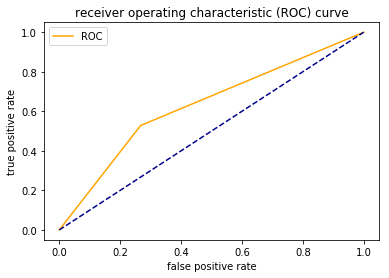

In [16]:
probs = clf_best.predict_proba(x_test_best)
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(y_test_best, probs)
plot_roc_cur(fper, tper)

from sklearn.externals.six import StringIO
from IPython.display import Image
# from IPython.display import SVG
# from IPython.display import display
# from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus

file = StringIO()
export_graphviz(clf, out_file=file, special_characters=True)
graph = pydotplus.graph_from_dot_data(file.getvalue())
Image(graph.create_png())
# graph = Source(export_graphviz(clf, out_file=None))
# display(SVG(graph.pipe(format='svg')))

In [17]:
df_reg['percentage'] = df_reg.apply(lambda row: row['usd_pledged'] / row['usd_goal'], axis=1)
x_reg = df_reg.copy()
del x_reg['percentage']
del x_reg['usd_pledged']
y_reg = df_reg['percentage'].copy()

reg = DecisionTreeRegressor(criterion='mse')
scores_reg = []
score_max = 0
reg_best = DecisionTreeRegressor()
x_test_best = pd.DataFrame()
y_test_best = pd.Series()
split_best = 0
for i in np.arange(0.1, 1.0, 0.1):
    x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=1-i, random_state=42)
    reg = reg.fit(x_train_reg, y_train_reg)
    # y_pred = reg.predict(x_test)
    # scores_reg.append([i, metrics.mean_absolute_error(y_test, y_pred), metrics.mean_squared_error(y_test, y_pred)])
    scores_reg.append([i, reg.score(x_test_reg, y_test_reg)])
# pd.DataFrame(scores_reg, columns=['train_size', 'mean absolute error', 'mean squared error'])
pd.DataFrame(scores_reg, columns=['train_size', 'test_accuracy'])

,train_size,test_accuracy
0,0.1,0.024671
1,0.2,0.000137
2,0.3,0.307280
3,0.4,0.285936
4,0.5,0.307187
5,0.6,0.002269
6,0.7,-0.329323
7,0.8,0.035689
8,0.9,-0.019939


In [18]:
# K-nearest neighbors
# clf = KNeighborsClassifier()
scores_clf = []
score_max = 0
clf_best = KNeighborsClassifier()
x_test_best = pd.DataFrame()
y_test_best = pd.Series()
split_best = 0
# k_list = [101, 151, 201, 301, 501]
for i in np.arange(0.1, 1.0, 0.1):
    #for k in k_list:
        # for k in np.arange(1, 6, 1):
    k = int(math.sqrt(i * x.shape[0]))
    if (k % 2 == 0):
        k += 1
    clf = KNeighborsClassifier(n_neighbors=k)
    x_train, x_test, y_train, y_test = train_test_split(x, y_success, test_size=1-i, random_state=42)
    clf = clf.fit(x_train, y_train)
    if clf.score(x_test, y_test) > score_max:
        score_max = clf.score(x_test, y_test)
        clf_best = clf
        x_test_best = x_test
        y_test_best = y_test
        split_best = i
    scores_clf.append([k, clf.score(x_test, y_test)])
print('Best train size: ' + str(split_best))
print('Max score: ' + str(score_max))

Best train size: 0.9
Max score: 0.6823394495412844


In [19]:
pd.DataFrame(scores_clf, columns=['k_neighbors', 'test_accuracy']).sort_values(by='k_neighbors', axis=0)

,k_neighbors,test_accuracy
0,41,0.662609
1,59,0.660597
2,73,0.659620
3,83,0.664850
4,93,0.669726
5,103,0.668770
6,111,0.666412
7,119,0.672211
8,125,0.682339


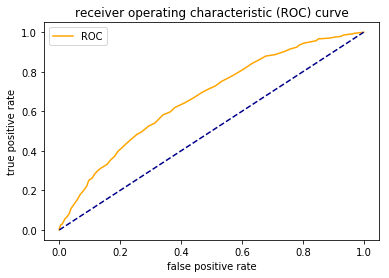

In [20]:
probs = clf_best.predict_proba(x_test_best)
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(y_test_best, probs)
plot_roc_cur(fper, tper)

In [21]:
# neural nets
from __future__ import print_function
np.random.seed(42)
scores_mlp = []
# hidden_layer_size = int(2/3 * df.shape[1] + 1)
lr = 0.01
for i in np.arange(0.1, 1.0, 0.1):
    # for lr in [0.0001, 0.001, 0.01]:
    for s in [10, 20, 22, 30]:
        x_train, x_test, y_train, y_test = train_test_split(x, y_success, test_size=1-i, random_state=42)
        mlp = MLPClassifier(hidden_layer_sizes=s, learning_rate_init = lr)
        mlp = mlp.fit(x_train, y_train)
        scores_mlp.append([i, lr, s, mlp.score(x_test, y_test)])
pd.DataFrame(scores_mlp, columns=['train_size', 'learning_rate', 'hidden_layer_size', 'test_accuracy'])

,train_size,learning_rate,hidden_layer_size,test_accuracy
0,0.1,0.01,10,0.670512
1,0.1,0.01,20,0.431266
2,0.1,0.01,22,0.547639
3,0.1,0.01,30,0.608757
4,0.2,0.01,10,0.659234
5,0.2,0.01,20,0.344135
6,0.2,0.01,22,0.657012
7,0.2,0.01,30,0.661027
8,0.3,0.01,10,0.674123
9,0.3,0.01,20,0.674041


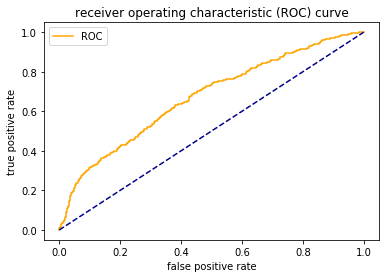

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y_success, test_size=0.1, random_state=42)
mlp_best = MLPClassifier(hidden_layer_sizes=20, learning_rate_init = 0.01)
mlp_best = mlp_best.fit(x_train, y_train)
probs = mlp_best.predict_proba(x_test)
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(y_test, probs)
plot_roc_cur(fper, tper)

In [23]:
mlp_best.score(x_test, y_test)

0.6834862385321101